In [1]:
%matplotlib inline

In [2]:
import numpy as np 
import pandas as pd 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt  
from sklearn.cluster import AgglomerativeClustering 

<hr>
<h1 id="clustering_vehicle_dataset">Clustering on Vehicle dataset</h1>

* Imaginez qu'un constructeur automobile développe des prototypes pour un nouveau véhicule. Avant d'introduire le nouveau modèle dans sa gamme, le constructeur souhaite déterminer quels véhicules existants sur le marché ressemblent le plus aux prototypes, c'est-à-dire comment les véhicules peuvent être regroupés, quel groupe est le plus similaire au modèle, et avec quels modèles ils seront en concurrence.

* Notre objectif ici est d'utiliser une méthode de regroupement pour trouver les groupes de véhicules les plus distinctifs. Il résumera les véhicules existants et aidera les constructeurs à prendre des décisions concernant la fourniture de nouveaux modèles.



## Chargement du dataset

* Lisons l'ensemble de données pour voir quelles fonctionnalités le fabricant a collectées sur les modèles existants.


In [3]:
filename = 'cars_clus.csv'

#Read csv
pdf = pd.read_csv(filename)
print ("shape du dataset: ", pdf.shape)

pdf.head(5)

shape du dataset:  (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


* Les ensembles de fonctionnalités incluent le prix en milliers (prix), la taille du moteur (engine_s), la puissance (horsepow), l'empattement (wheelbas), la largeur (width), la longueur (length), le poids à vide (curb_wgt), la capacité de carburant (fuel_cap) et le carburant efficacité (mpg).

<h2 id="data_cleaning">Pretraitement</h2>

In [4]:
pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = pdf[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')

In [5]:
pdf.isna().sum()

manufact      2
model         0
sales         2
resale       38
type          2
price         2
engine_s      1
horsepow      1
wheelbas      1
width         1
length        1
curb_wgt      2
fuel_cap      1
mpg           3
lnsales       2
partition     0
dtype: int64

In [6]:
features = pdf[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']]

features.isnull().sum()

sales        2
resale      38
type         2
price        2
engine_s     1
horsepow     1
wheelbas     1
width        1
length       1
curb_wgt     2
fuel_cap     1
mpg          3
lnsales      2
dtype: int64

In [7]:
for i in features.columns:
    features[i].replace(np.nan, features[i].mean(), inplace = True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7568\1463091702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[i].replace(np.nan, features[i].mean(), inplace = True)


In [8]:
features.isnull().sum()

sales       0
resale      0
type        0
price       0
engine_s    0
horsepow    0
wheelbas    0
width       0
length      0
curb_wgt    0
fuel_cap    0
mpg         0
lnsales     0
dtype: int64

In [9]:
pdf['manufact'].mode()

0    Dodge
1     Ford
Name: manufact, dtype: object

In [10]:
pdf['manufact'].replace(np.nan, 'Dodge', inplace = True)

In [11]:
pdf.drop(pdf[['sales', 'resale', 'type', 'price', 'engine_s','horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']], axis=1, inplace = True)
print(pdf)

    manufact     model  partition
0      Acura   Integra        0.0
1      Acura        TL        0.0
2      Acura        CL        0.0
3      Acura        RL        0.0
4       Audi        A4        0.0
..       ...       ...        ...
154    Volvo       V70        0.0
155    Volvo       C70        0.0
156    Volvo       S80        0.0
157    Dodge    newCar        1.0
158    Dodge  newTruck        1.0

[159 rows x 3 columns]


In [12]:
pdf = pd.concat([pdf, features], axis = 1)
pdf

,manufact,model,partition,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales
0,Acura,Integra,0.0,16.919000,16.360000,0.000000,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828000
1,Acura,TL,0.0,39.384000,19.875000,0.000000,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673000
2,Acura,CL,0.0,14.114000,18.225000,0.000000,27.396605,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,2.647000
3,Acura,RL,0.0,8.588000,29.725000,0.000000,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150000
4,Audi,A4,0.0,20.397000,22.255000,0.000000,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,Volvo,V70,0.0,17.531000,18.072975,0.000000,28.800000,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,2.864000
155,Volvo,C70,0.0,3.493000,18.072975,0.000000,45.500000,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,1.251000
156,Volvo,S80,0.0,18.969000,18.072975,0.000000,36.000000,2.9,201.0,109.9,72.1,189.8,3.600,21.1,24.0,2.943000
157,Dodge,newCar,1.0,52.998076,18.072975,0.261146,21.500000,1.5,76.0,106.3,67.9,175.0,2.932,11.9,46.0,3.295847


* price et engine_s

* horsepow et mpg

### Selection des fonctionnalités

In [13]:
featureset = features[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]

### Normalisation

* Nous utilisons **MinMaxScaler** pour mettre nos featureset sur une plage de (0, 1) 


In [14]:
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.2716763 , 0.30625832,
        0.20233886, 0.13364055, 0.41935484],
       [0.31428571, 0.43037975, 0.3362256 , 0.44508671, 0.5792277 ,
        0.44112048, 0.31797235, 0.32258065],
       [0.31428571, 0.43037975, 0.31019523, 0.46242775, 0.56724368,
        0.42833832, 0.31797235, 0.35483871],
       [0.35714286, 0.39240506, 0.47722343, 0.50867052, 0.62849534,
        0.53168344, 0.35483871, 0.22580645],
       [0.11428571, 0.24050633, 0.21691974, 0.32369942, 0.38082557,
        0.2999728 , 0.28110599, 0.38709677]])

In [15]:
feature_mtx.shape

(159, 8)

<h2 id="clustering_using_skl">Regroupement</h2>


* Nous calculons la matrice de distance

In [31]:
dist_matrix = euclidean_distances(feature_mtx, feature_mtx) 
dist_matrix

array([[0.        , 0.56004708, 0.54342465, ..., 0.6575048 , 0.62435289,
        0.80552727],
       [0.56004708, 0.        , 0.04822732, ..., 0.23115617, 0.9070353 ,
        0.42690608],
       [0.54342465, 0.04822732, 0.        , ..., 0.23633051, 0.879962  ,
        0.42431572],
       ...,
       [0.6575048 , 0.23115617, 0.23633051, ..., 0.        , 0.98000482,
        0.38034196],
       [0.62435289, 0.9070353 , 0.879962  , ..., 0.98000482, 0.        ,
        1.00496569],
       [0.80552727, 0.42690608, 0.42431572, ..., 0.38034196, 1.00496569,
        0.        ]])

In [33]:
Z_using_dist_matrix = hierarchy.linkage(dist_matrix, method = 'complete')
Z_using_dist_matrix.shape

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7568\2503498857.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_using_dist_matrix = hierarchy.linkage(dist_matrix, method = 'complete')


(158, 4)

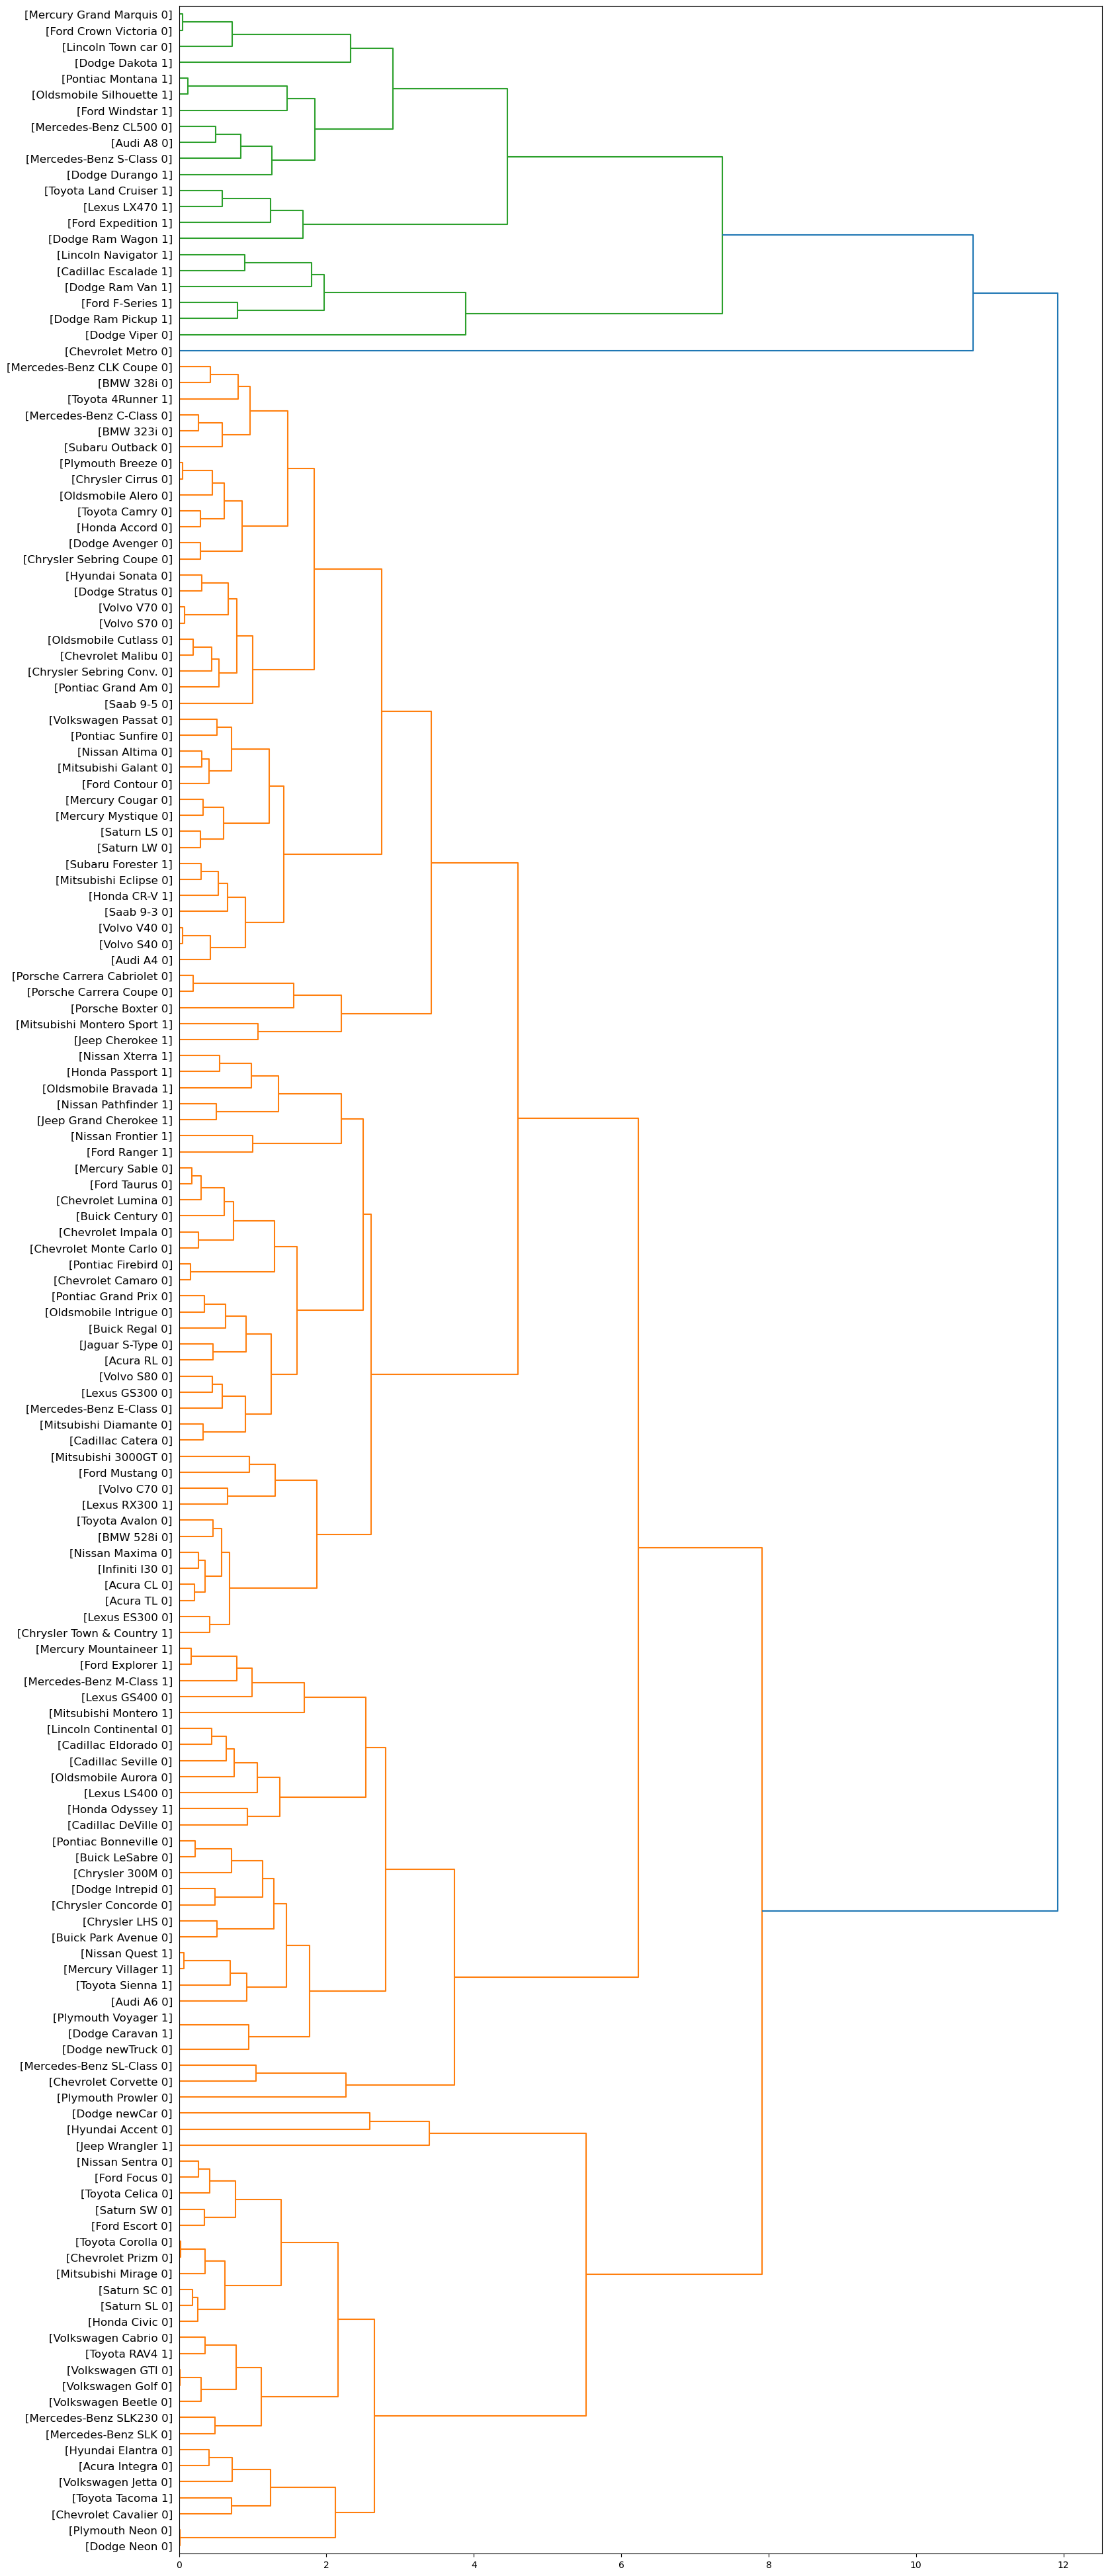

In [18]:
fig = plt.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (pdf['manufact'][id], pdf['model'][id], int(float(pdf['type'][id])) )
    
dendro = hierarchy.dendrogram(Z_using_dist_matrix,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

In [19]:
dendro.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list', 'leaves_color_list'])

* Nous utilisons **AgglomerativeClustering** de la bibliothèque scikit-learn pour regrouper l'ensemble de donnée par cluster

In [21]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(dist_matrix)

# agglom.labels_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


AgglomerativeClustering(linkage='complete', n_clusters=6)

In [22]:
# agg_cluster = np.unique(agglom.labels_)

In [23]:
# agg_cluster

* price vs engine_s

In [24]:
# price_vs_engine = pdf[['price', 'engine_s']].to_numpy()

In [25]:
# plt.figure(1, figsize = (10, 6))
# colors = ('red', 'blue', 'yellow', 'orange', 'green', 'cyan')
# for i in list(agg_cluster):
#     plt.scatter(x = pdf['price'], y = pdf['engine_s'], data = pdf, s=100, label = i)
#     plt.scatter(x = 'price', y = 'engine_s')
# plt.legend()
# plt.show()

* Nous pouvons ajouter un nouveau champ à notre dataframe pour afficher le cluster de chaque ligne

In [26]:
pdf['cluster_'] = agglom.labels_
pdf.head()

,manufact,model,partition,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,cluster_
0,Acura,Integra,0.0,16.919,16.360,0.0,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0
1,Acura,TL,0.0,39.384,19.875,0.0,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,1
2,Acura,CL,0.0,14.114,18.225,0.0,27.396605,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,2.647,1
3,Acura,RL,0.0,8.588,29.725,0.0,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,1
4,Audi,A4,0.0,20.397,22.255,0.0,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,1


* horsepow vs mpg

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

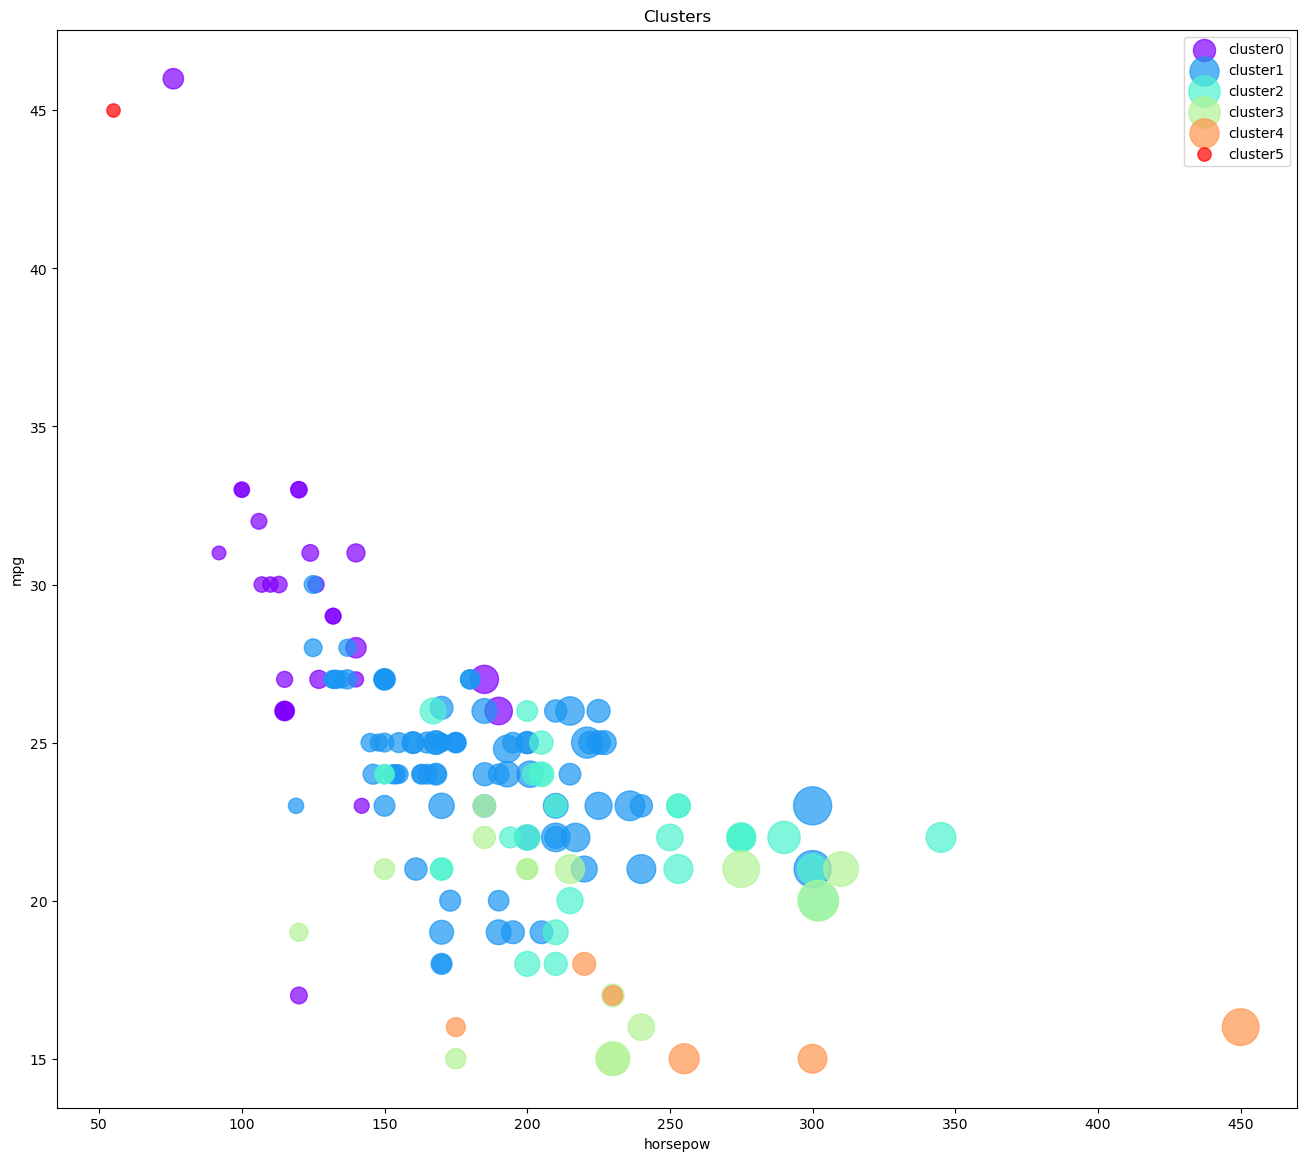

In [27]:
import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))

cluster_labels = list(range(0, n_clusters))

plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = pdf[pdf.cluster_ == label]
#     for i in subset.index:
#         plt.text(subset.horsepow[i], subset.mpg[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.7)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg');

* Comme vous pouvez le voir, nous voyons la distribution de chaque cluster à l'aide du nuage de points, mais il n'est pas très clair où se trouve le centroïde de chaque cluster. De plus, il existe 2 types de véhicules dans notre jeu de données, "camion" (valeur de 1 dans la colonne type) et "voiture" (valeur de 0 dans la colonne type). Nous les utilisons donc pour distinguer les classes et résumer le cluster. Nous comptons d'abord le nombre de cas dans chaque groupe :


In [28]:
pdf.groupby(['cluster_','type'])['cluster_'].count()

cluster_  type    
0         0.000000    24
          0.261146     1
          1.000000     3
1         0.000000    66
          1.000000    14
2         0.000000    18
          0.261146     1
          1.000000    10
3         0.000000     6
          1.000000     9
4         0.000000     1
          1.000000     5
5         0.000000     1
Name: cluster_, dtype: int64

Nous pouvons maintenant examiner les caractéristiques de chaque cluster 

In [29]:
agg_cars = pdf.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()

agg_cars

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7568\2708693241.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  agg_cars = pdf.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()


horsepow  engine_s        mpg      price
cluster_ type                                                
0        0.000000  123.625000  1.933333  29.166667  16.359875
         0.261146   76.000000  1.500000  46.000000  21.500000
         1.000000  129.666667  2.300000  22.333333  14.292000
1        0.000000  182.045455  2.769697  24.831808  26.552252
         1.000000  174.866637  3.153843  20.785668  24.015186
2        0.000000  253.500000  3.955556  22.611075  38.377167
         0.261146  167.000000  3.500000  26.000000  34.200000
         1.000000  187.900000  3.260000  21.000000  26.228900
3        0.000000  250.333333  4.550000  20.833333  50.888333
         1.000000  193.888889  3.933333  18.111111  31.662556
4        0.000000  450.000000  8.000000  16.000000  69.725000
         1.000000  236.000000  4.960000  16.200000  30.771000
5        0.000000   55.000000  1.000000  45.000000   9.235000

Nous avons 3 clusters principaux avec la majorité des véhicules dans ceux-ci.

**Voitures**:

* Groupe 1 : avec un mpg presque élevé et une faible puissance.

* Groupe 2 : avec un bon mpg et une bonne puissance, mais un prix plus élevé que la moyenne.

* Groupe 3 : avec un faible mpg, une puissance élevée, le prix le plus élevé.

**Camions** :

* Groupe 1 : avec le mpg presque le plus élevé parmi les camions, et le plus bas en puissance et en prix.
* Groupe 2 : avec un mpg presque bas et une puissance moyenne, mais un prix plus élevé que la moyenne.
* Groupe 3 : avec un bon mpg et une bonne puissance, à bas prix.



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

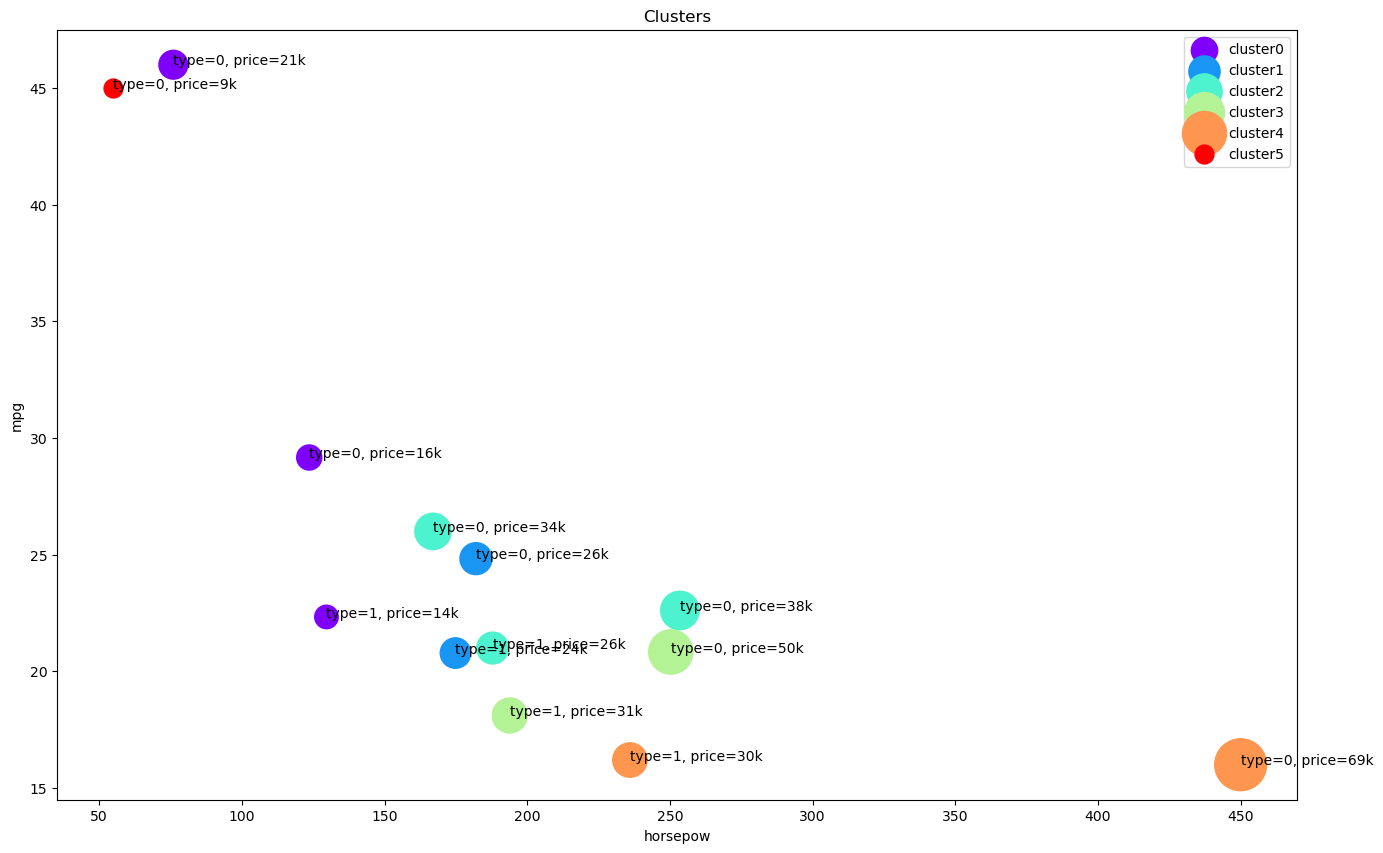

In [30]:
plt.figure(figsize=(16,10))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0], subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, c=color, label='cluster'+str(label))
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg');